# Link Google Colab
[Google Colab](https://colab.research.google.com/drive/10hsEMv1y66oXtQ-xAQTqCJ7eR508akQg?usp=sharing)

## Install and Import Library

In [ ]:
!pip install skforecast session_info
!pip install optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00
  Created wheel for session_info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=2bf8d8374834fa8f44e98899163ead035f248822fdddf7fe74dd852ebcb7f984
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session_info


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from datetime import datetime
import pytz

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

## Load Data

In [ ]:
!wget https://github.com/hilmizr/world_fertilizer_price/raw/master/01-09-24-modified_fertilizer_datav5.xlsx

--2024-09-04 23:33:27--  https://github.com/hilmizr/world_fertilizer_price/raw/master/01-09-24-modified_fertilizer_datav5.xlsx
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hilmizr/world_fertilizer_price/master/01-09-24-modified_fertilizer_datav5.xlsx [following]
--2024-09-04 23:33:27--  https://raw.githubusercontent.com/hilmizr/world_fertilizer_price/master/01-09-24-modified_fertilizer_datav5.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42737 (42K) [application/octet-stream]
Saving to: ‘01-09-24-modified_fertilizer_datav5.xlsx’

01-09-24-modified_f 100%[===================>]  41.74K

In [ ]:
date_col = 'date'
target_col = 'urea_price'

In [ ]:
data = pd.read_excel('01-09-24-modified_fertilizer_datav5.xlsx')
data

,date,dap_price,kcl_price,rock_price,tsp_price,urea_price
0,1993-11-01,140.40,112.50,31.5,112.50,82.80
1,1993-12-01,150.38,112.50,31.5,122.50,85.50
2,1994-01-01,150.00,112.50,31.5,125.00,85.50
3,1994-02-01,151.75,112.50,31.5,125.63,85.50
4,1994-03-01,155.88,112.50,31.5,127.50,98.63
...,...,...,...,...,...,...
361,2023-12-01,563.75,311.88,152.5,447.50,354.00
362,2024-01-01,596.25,296.25,152.5,450.63,335.38
363,2024-02-01,583.81,289.38,152.5,454.38,351.25
364,2024-03-01,617.50,300.50,152.5,449.00,330.00


# Data Preparation

## Format Data

In [ ]:
data[date_col] = pd.to_datetime(data[date_col])
data.set_index(date_col, inplace=True)
data = data.asfreq('MS')

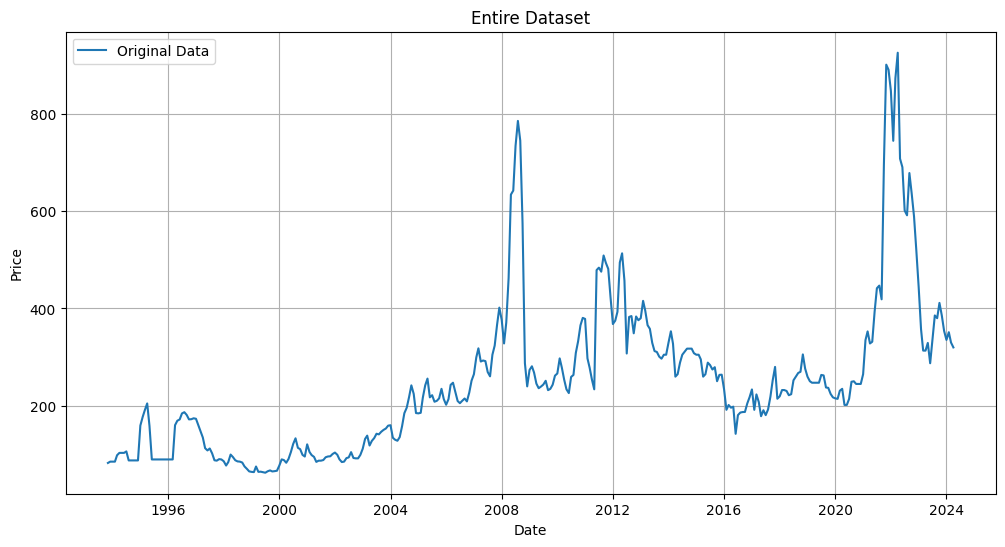

In [ ]:
# Plot the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[target_col], label='Original Data')
plt.title('Entire Dataset')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Detect and Interpolate Null and Zero Values
- Dilakukan pencarian nilai kosong (`null`/NaN/0) dalam dataset
- Jika ditemukan, akan diisi dengan interpolasi linear. Interpolasi ini menghitung nilai yang hilang berdasarkan pola data sebelum dan sesudahnya.
- Jika setelah interpolasi linear, masih terdapat nilai kosong, akan diisi dengan metode forward fill (mengisi dengan nilai sebelumnya) dan backward fill (mengisi dengan nilai sesudahnya)

In [ ]:
data[target_col].isnull().sum()

0

In [ ]:
data[target_col] = data[target_col].replace(0, np.nan)
if data[target_col].isnull().any():
  data[target_col] = data[target_col].interpolate(method='linear')
  data[target_col] = data[target_col].fillna(method='ffill').fillna(method='bfill')

## Train Test Split
- Data dibagi menjadi train dan test
- Dalam contoh di bawah, digunakan 6 bulan terakhir sebagai data test

In [ ]:
n_test = 6

In [ ]:
train_data, test_data = train_test_split(data, test_size=n_test, shuffle=False)

In [ ]:
train_data

,dap_price,kcl_price,rock_price,tsp_price,urea_price
date,,,,,
1993-11-01,140.40,112.50,31.50,112.50,82.80
1993-12-01,150.38,112.50,31.50,122.50,85.50
1994-01-01,150.00,112.50,31.50,125.00,85.50
1994-02-01,151.75,112.50,31.50,125.63,85.50
1994-03-01,155.88,112.50,31.50,127.50,98.63
...,...,...,...,...,...
2023-06-01,454.55,328.00,344.50,390.00,287.50
2023-07-01,458.75,341.25,342.50,392.25,334.63
2023-08-01,528.75,353.13,346.25,450.63,385.63


In [ ]:
test_data

,dap_price,kcl_price,rock_price,tsp_price,urea_price
date,,,,,
2023-11-01,535.63,331.88,347.5,462.63,385.50
2023-12-01,563.75,311.88,152.5,447.50,354.00
2024-01-01,596.25,296.25,152.5,450.63,335.38
2024-02-01,583.81,289.38,152.5,454.38,351.25
2024-03-01,617.50,300.50,152.5,449.00,330.00
2024-04-01,545.00,305.00,152.5,442.50,320.00


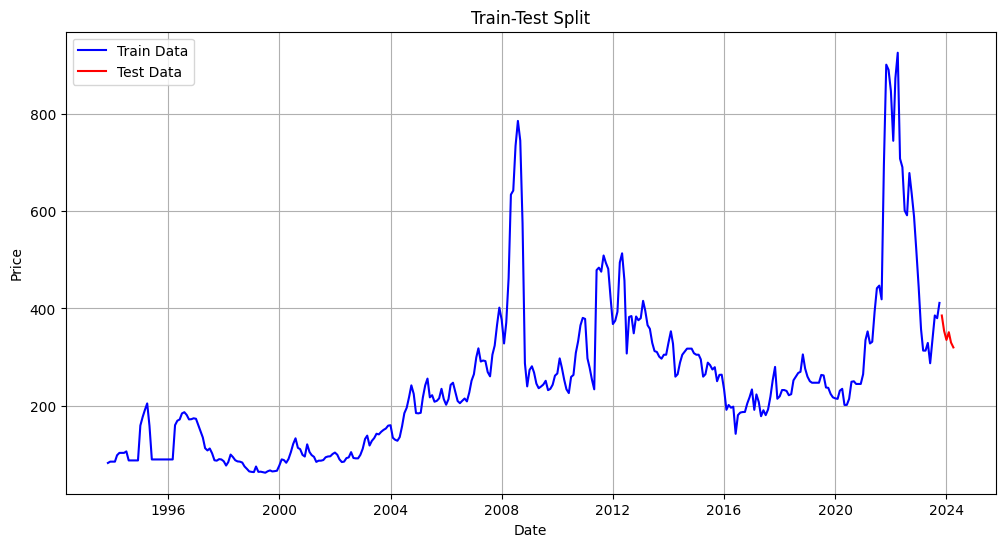

In [ ]:
# Plot the train and test split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data[target_col], label='Train Data', color='blue')
plt.plot(test_data.index, test_data[target_col], label='Test Data', color='red')
plt.title('Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Basic Modeling
Modeling dilakukan dengan bantuan library Skforecast. Skforecast membantu menyesuaikan model regresi machine learning (seperti XGBRegressor) supaya bisa digunakan untuk time series forecasting.

In [ ]:
regressor = XGBRegressor(random_state=123)

## Define Forecaster
- Model regresi digunakan dalam objek forecaster. Supaya model regresi machine learning dapat dipakai untuk time series forecasting, perlu menggunakan variabel lag.
- Dalam objek forecaster, jumlah variable lag ditentukan oleh parameter `lags`.
- Jumlah variabel lag dapat menjadi salah satu parameter yang di-tuning untuk meminimalkan kesalahan.

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor       = regressor,
                 lags            = 12,
             )

## Fit Forecaster

In [ ]:
forecaster.fit(y=train_data[target_col])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

## Predict

In [ ]:
predictions = forecaster.predict(n_test)

In [ ]:
predictions

,pred
2023-11-01,338.735596
2023-12-01,338.522064
2024-01-01,360.287140
2024-02-01,346.510162
2024-03-01,363.269531
2024-04-01,352.285492


## Compare

In [ ]:
actual = test_data[target_col].values
pred = predictions

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index
comparison_df

,Actual,Predicted
date,,
2023-11-01,385.50,338.735596
2023-12-01,354.00,338.522064
2024-01-01,335.38,360.287140
2024-02-01,351.25,346.510162
2024-03-01,330.00,363.269531
2024-04-01,320.00,352.285492


## Evaluate

In [ ]:
def evaluate_forecast(y_true, y_pred):
    results = {
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return pd.Series(results)

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.075750
RMSE,29.491587
MAE,26.240723
R2,-0.935227


## Recap

In [ ]:
evaluation_summary = pd.DataFrame(columns=['Is Imputed?',
                                           'Scaler',
                                           'Lags',
                                           'Differentiation',
                                           'BoxCox'])

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Is Imputed?'] = False
temp_eval['Scaler'] = 'None'
temp_eval['Lags'] = 12
temp_eval['Differentiation'] = 'None'
temp_eval['BoxCox'] = False
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Is Imputed?,Scaler,Lags,Differentiation,BoxCox,MAPE,RMSE,MAE,R2
0,False,None,12,None,False,0.07575,29.491587,26.240723,-0.935227


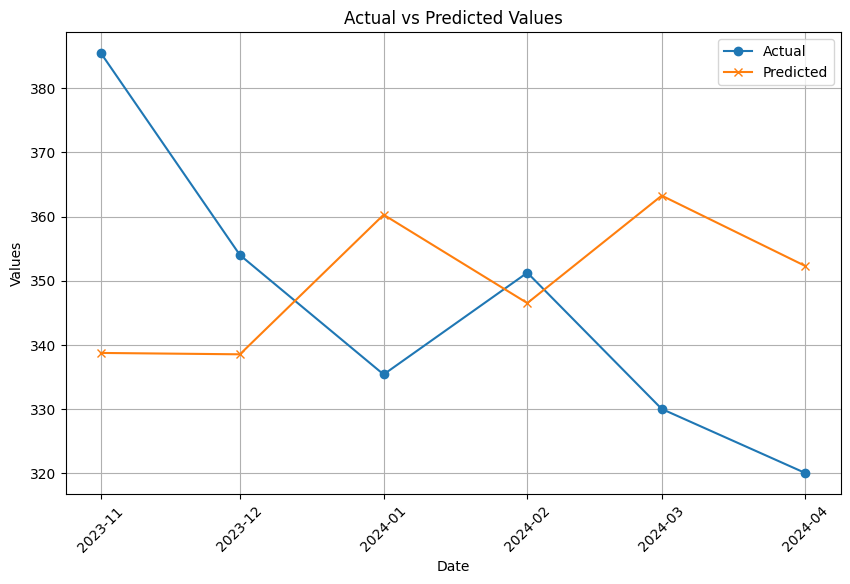

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Save / Load Forecaster
Dalam skforecast, model atau forecaster yang sudah kita latih, dapat disimpan dan dimuat sebagai file joblib.

In [ ]:
save_forecaster(
    forecaster,
    file_name='basic_model.joblib',
    verbose=True)

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

In [ ]:
forecaster_loaded = load_forecaster('basic_model.joblib')

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

# Modeling + Outlier Handling

## Define Outlier Imputation

In [ ]:
def detect_and_impute_outlier(data, target_col) :
  Q1, Q3 = data[target_col].quantile([0.25, 0.75])
  IQR = Q3 - Q1
  outlier_indices = data[(data[target_col] < Q1 - 1.5 * IQR) | (data[target_col] > Q3 + 1.5 * IQR)].index

  imputer = SimpleImputer(strategy='median')
  imputed_data = pd.DataFrame(index=train_data.index, data=train_data[target_col])
  imputed_data.loc[outlier_indices, target_col] = np.nan
  imputed_data[target_col] = imputer.fit_transform(imputed_data)

  result = data.copy(deep=True)
  result[target_col] = imputed_data[target_col]

  return result

## Apply Outlier Imputation

In [ ]:
imputed_train_data = detect_and_impute_outlier(train_data, target_col)
display(imputed_train_data)

,dap_price,kcl_price,rock_price,tsp_price,urea_price
date,,,,,
1993-11-01,140.40,112.50,31.50,112.50,82.80
1993-12-01,150.38,112.50,31.50,122.50,85.50
1994-01-01,150.00,112.50,31.50,125.00,85.50
1994-02-01,151.75,112.50,31.50,125.63,85.50
1994-03-01,155.88,112.50,31.50,127.50,98.63
...,...,...,...,...,...
2023-06-01,454.55,328.00,344.50,390.00,287.50
2023-07-01,458.75,341.25,342.50,392.25,334.63
2023-08-01,528.75,353.13,346.25,450.63,385.63


## Define Forecaster

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor       = regressor,
                 lags            = 12,
             )

## Fit Forecaster

In [ ]:
forecaster.fit(y=imputed_train_data[target_col])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

## Predict

In [ ]:
predictions = forecaster.predict(n_test)

In [ ]:
predictions

,pred
2023-11-01,441.195892
2023-12-01,359.130920
2024-01-01,339.618378
2024-02-01,354.704071
2024-03-01,326.028076
2024-04-01,293.536865


## Compare

In [ ]:
actual = test_data[target_col].values
pred = predictions

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index
comparison_df

,Actual,Predicted
date,,
2023-11-01,385.50,441.195892
2023-12-01,354.00,359.130920
2024-01-01,335.38,339.618378
2024-02-01,351.25,354.704071
2024-03-01,330.00,326.028076
2024-04-01,320.00,293.536865


## Evaluate

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.046029
RMSE,25.411044
MAE,16.492387
R2,-0.436748


## Recap

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Is Imputed?'] = True
temp_eval['Scaler'] = 'None'
temp_eval['Lags'] = 12
temp_eval['Differentiation'] = 'None'
temp_eval['BoxCox'] = False
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Is Imputed?,Scaler,Lags,Differentiation,BoxCox,MAPE,RMSE,MAE,R2
0,False,None,12,None,False,0.075750,29.491587,26.240723,-0.935227
1,True,None,12,None,False,0.046029,25.411044,16.492387,-0.436748


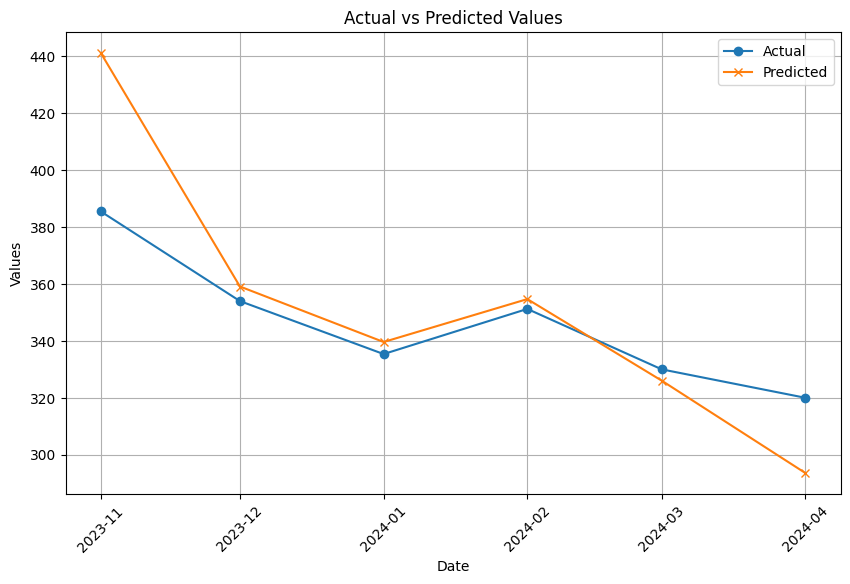

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Save / Load Forecaster

In [ ]:
save_forecaster(
    forecaster,
    file_name='basic_model+outlier_handling.joblib',
    verbose=True)

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

In [ ]:
forecaster_loaded = load_forecaster('basic_model+outlier_handling.joblib')

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

# Modeling + Outlier Handling + BoxCox Transform

## Define BoxCox Transform

In [ ]:
from scipy.stats import boxcox
def apply_transformation(data):
  transformed_data, lambda_value = boxcox(data)
  return transformed_data, lambda_value

## Apply BoxCox Transform

In [ ]:
transformed_train_data = imputed_train_data.copy(deep=True)
transformed_train_data[target_col], lambda_value = apply_transformation(imputed_train_data[target_col])
transformed_train_data

,dap_price,kcl_price,rock_price,tsp_price,urea_price
date,,,,,
1993-11-01,140.40,112.50,31.50,112.50,11.613838
1993-12-01,150.38,112.50,31.50,122.50,11.790360
1994-01-01,150.00,112.50,31.50,125.00,11.790360
1994-02-01,151.75,112.50,31.50,125.63,11.790360
1994-03-01,155.88,112.50,31.50,127.50,12.603237
...,...,...,...,...,...
2023-06-01,454.55,328.00,344.50,390.00,20.343154
2023-07-01,458.75,341.25,342.50,392.25,21.722694
2023-08-01,528.75,353.13,346.25,450.63,23.086690


## Define Forecaster

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor       = regressor,
                 lags            = 12,
             )

## Fit Forecaster

In [ ]:
forecaster.fit(y=transformed_train_data[target_col])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

## Predict

In [ ]:
predictions = forecaster.predict(n_test)

In [ ]:
predictions

,pred
2023-11-01,24.169657
2023-12-01,22.510794
2024-01-01,22.164312
2024-02-01,22.179449
2024-03-01,21.686590
2024-04-01,21.840055


#### Inverse Transformation

In [ ]:
from scipy.special import inv_boxcox
def inverse_transformation(transformed_data, lambda_value):
    if lambda_value is not None:
        return inv_boxcox(transformed_data, lambda_value)
    else:
        return transformed_data

In [ ]:
inversed_predictions = inverse_transformation(predictions, lambda_value)
inversed_predictions

,pred
2023-11-01,429.335880
2023-12-01,363.553908
2024-01-01,350.655967
2024-02-01,351.213458
2024-03-01,333.340196
2024-04-01,338.843994


## Compare

In [ ]:
actual = test_data[target_col].values
pred = inversed_predictions

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index
comparison_df

,Actual,Predicted
date,,
2023-11-01,385.50,429.335880
2023-12-01,354.00,363.553908
2024-01-01,335.38,350.655967
2024-02-01,351.25,351.213458
2024-03-01,330.00,333.340196
2024-04-01,320.00,338.843994


## Evaluate

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.042560
RMSE,20.866524
MAE,15.147748
R2,0.031196


## Recap

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Is Imputed?'] = True
temp_eval['Scaler'] = 'None'
temp_eval['Lags'] = 12
temp_eval['Differentiation'] = 'None'
temp_eval['BoxCox'] = True
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Is Imputed?,Scaler,Lags,Differentiation,BoxCox,MAPE,RMSE,MAE,R2
0,False,None,12,None,False,0.075750,29.491587,26.240723,-0.935227
1,True,None,12,None,False,0.046029,25.411044,16.492387,-0.436748
2,True,None,12,None,True,0.042560,20.866524,15.147748,0.031196


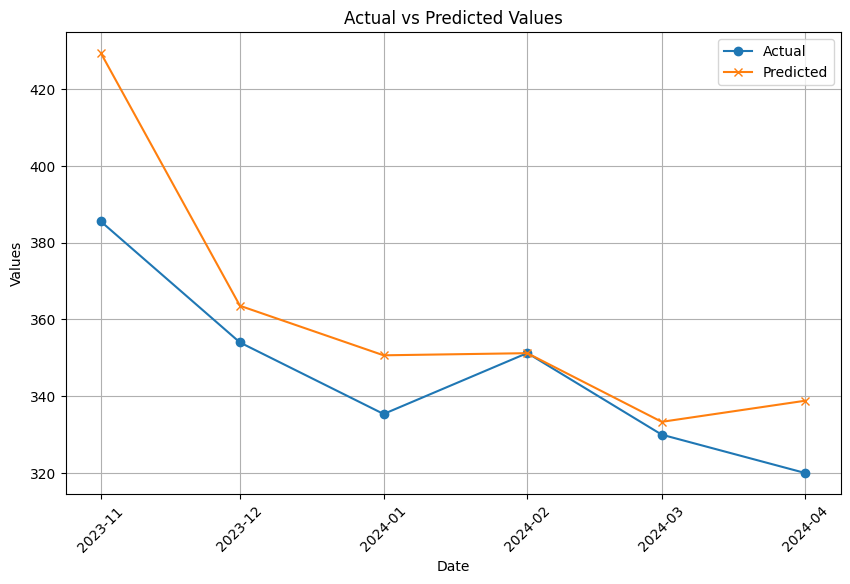

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Save / Load Forecaster

In [ ]:
save_forecaster(
    forecaster,
    file_name='basic_model+outlier_handling+boxcox.joblib',
    verbose=True)

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

In [ ]:
forecaster_loaded = load_forecaster('basic_model+outlier_handling+boxcox.joblib')

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables

# Modeling + Outlier Handling + BoxCox Transform + Differencing

## Define Forecaster with Differentiation

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor       = regressor,
                 differentiation = 1,
                 lags            = 12,
             )

## Fit Forecaster

In [ ]:
forecaster.fit(y=transformed_train_data[target_col])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Exogenous variables na

## Predict

In [ ]:
predictions = forecaster.predict(n_test)

In [ ]:
predictions

,pred
2023-11-01,23.129317
2023-12-01,21.758750
2024-01-01,21.912328
2024-02-01,21.935408
2024-03-01,21.611511
2024-04-01,22.041678


## Inverse Transformation

In [ ]:
inversed_predictions = inverse_transformation(predictions, lambda_value)
inversed_predictions

,pred
2023-11-01,387.295950
2023-12-01,335.921190
2024-01-01,341.455186
2024-02-01,342.291626
2024-03-01,330.667767
2024-04-01,346.159377


## Compare

In [ ]:
actual = test_data[target_col].values
pred = inversed_predictions

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index
comparison_df

,Actual,Predicted
date,,
2023-11-01,385.50,387.295950
2023-12-01,354.00,335.921190
2024-01-01,335.38,341.455186
2024-02-01,351.25,342.291626
2024-03-01,330.00,330.667767
2024-04-01,320.00,346.159377


## Evaluate

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.030520
RMSE,13.735526
MAE,10.289244
R2,0.580216


## Recap

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Is Imputed?'] = True
temp_eval['Scaler'] = 'None'
temp_eval['Lags'] = 12
temp_eval['Differentiation'] = 1
temp_eval['BoxCox'] = True
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Is Imputed?,Scaler,Lags,Differentiation,BoxCox,MAPE,RMSE,MAE,R2
0,False,None,12,None,False,0.075750,29.491587,26.240723,-0.935227
1,True,None,12,None,False,0.046029,25.411044,16.492387,-0.436748
2,True,None,12,None,True,0.042560,20.866524,15.147748,0.031196
3,True,None,12,1,True,0.030520,13.735526,10.289244,0.580216


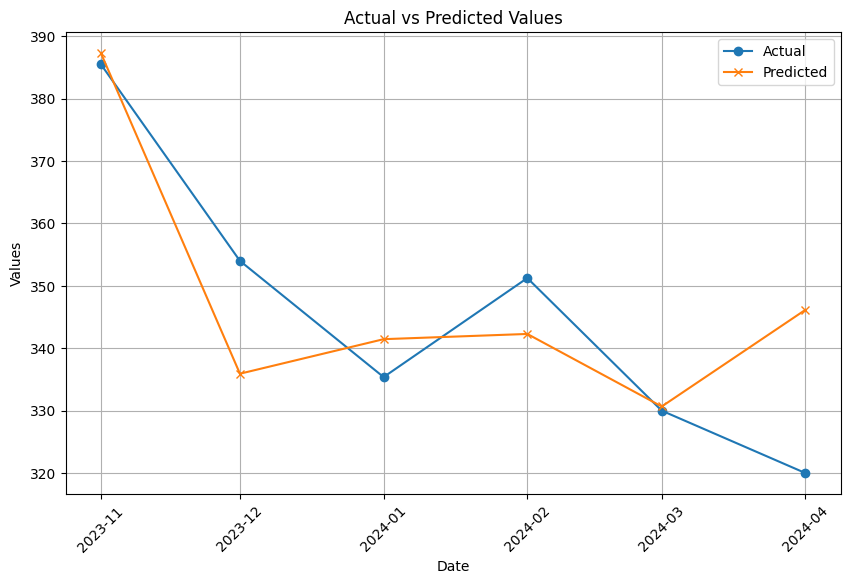

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Save / Load Forecaster

In [ ]:
save_forecaster(
    forecaster,
    file_name='basic_model+outlier_handling+boxcox+diff.joblib',
    verbose=True)

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Exogenous variables na

In [ ]:
forecaster_loaded = load_forecaster('basic_model+outlier_handling+boxcox+diff.joblib')

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Exogenous variables na

# Modeling + Outlier Handling + BoxCox Transform + Differencing + Scaling

## Define Forecaster with Differentiation

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor       = regressor,
                 differentiation = 1,
                 transformer_y = RobustScaler(),
                 lags            = 12,
             )

## Fit Forecaster

In [ ]:
forecaster.fit(y=transformed_train_data[target_col])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: RobustScaler() 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Exogenous va

## Predict

In [ ]:
predictions = forecaster.predict(n_test)

In [ ]:
predictions

,pred
2023-11-01,23.174511
2023-12-01,21.763314
2024-01-01,21.818364
2024-02-01,21.950271
2024-03-01,22.111917
2024-04-01,22.919587


## Inverse Transformation

In [ ]:
inversed_predictions = inverse_transformation(predictions, lambda_value)
inversed_predictions

,pred
2023-11-01,389.067054
2023-12-01,336.084833
2024-01-01,338.062685
2024-02-01,342.830961
2024-03-01,348.730433
2024-04-01,379.141814


## Compare

In [ ]:
actual = test_data[target_col].values
pred = inversed_predictions

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index
comparison_df

,Actual,Predicted
date,,
2023-11-01,385.50,389.067054
2023-12-01,354.00,336.084833
2024-01-01,335.38,338.062685
2024-02-01,351.25,342.830961
2024-03-01,330.00,348.730433
2024-04-01,320.00,379.141814


## Evaluate

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.055568
RMSE,26.646880
MAE,18.409365
R2,-0.579896


## Recap

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Is Imputed?'] = True
temp_eval['Scaler'] = 'RobustScaler'
temp_eval['Lags'] = 12
temp_eval['Differentiation'] = 1
temp_eval['BoxCox'] = True
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Is Imputed?,Scaler,Lags,Differentiation,BoxCox,MAPE,RMSE,MAE,R2
0,False,None,12,None,False,0.075750,29.491587,26.240723,-0.935227
1,True,None,12,None,False,0.046029,25.411044,16.492387,-0.436748
2,True,None,12,None,True,0.042560,20.866524,15.147748,0.031196
3,True,None,12,1,True,0.030520,13.735526,10.289244,0.580216
4,True,RobustScaler,12,1,True,0.055568,26.646880,18.409365,-0.579896


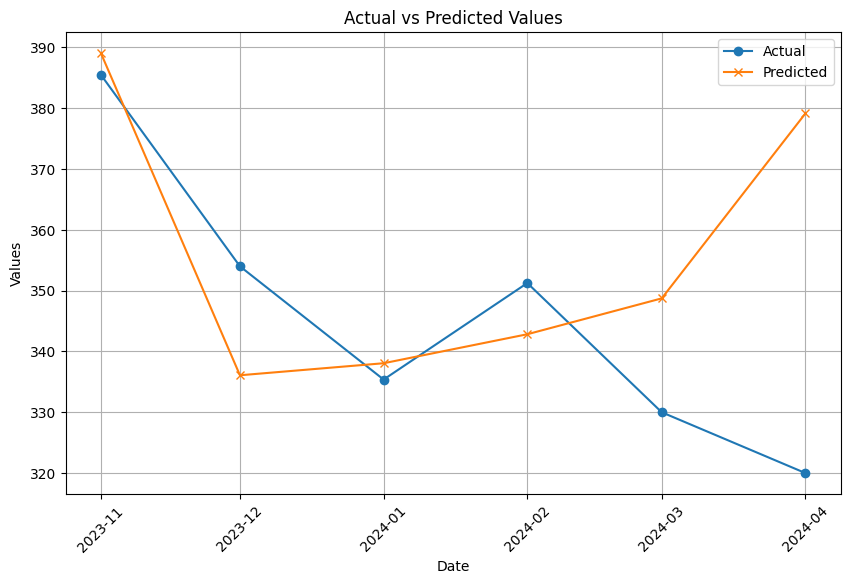

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Save / Load Forecaster

In [ ]:
save_forecaster(
    forecaster,
    file_name='basic_model+outlier_handling+boxcox+diff+scaling.joblib',
    verbose=True)

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: RobustScaler() 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Exogenous va

In [ ]:
forecaster_loaded = load_forecaster('basic_model+outlier_handling+boxcox+diff+scaling.joblib')

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: RobustScaler() 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Exogenous va